In this workbook we will identify molecules that are substrates and evaders in P.aeruginosa efflux compromised strain

In [1]:
# load conda environment
import sys
sys.path.append("/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/")

from ml_mmpa import master_functions

# data process
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles, venn2


from scipy import stats

import seaborn as sns

# text process for assays 
import re

import pickle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn import datasets, decomposition
from sklearn.manifold import TSNE

#chem

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors, Descriptors3D, Draw, rdMolDescriptors, Draw, PandasTools
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoSimMat, GetTanimotoDistMat
from rdkit.Chem.Draw import IPythonConsole

RDKit WARNING: [12:45:37] Enabling RDKit 2019.09.2 jupyter extensions


In [2]:
# import master data
inhibition = pd.read_csv('data/CO-ADD_InhibitionData_r03_01-02-2020_CSV.csv', low_memory=False)
# s_aureus_master = pd.read_csv('../data/master_s_aureus.csv', dtype=np.unicode_ , sep=';')
# import master data
dose_response = pd.read_csv('data/CO-ADD_DoseResponseData_r03_01-02-2020_CSV.csv', low_memory=False)
# s_aureus_master = pd.read_csv('../data/master_s_aureus.csv', dtype=np.unicode_ , sep=';')


In [4]:
inhibition[(inhibition['ORGANISM']=='Pseudomonas aeruginosa')].STRAIN.value_counts()

ATCC 27853                                                                                   100521
PAO397; PAO1 d(mexAB-oprM) d(mexCD-oprJ) d(mexEF-oprN) d(mexJKL) d(mexXY) d(opmH) d(pscC)     32405
PAO1                                                                                           1760
Name: STRAIN, dtype: int64

In [5]:
p_aer_wild = inhibition[(inhibition['ORGANISM']=='Pseudomonas aeruginosa') & (inhibition['STRAIN']=='ATCC 27853')][['SMILES', 'INHIB_AVE']].groupby('SMILES').mean().reset_index()

p_aer_efflux = inhibition[(inhibition['ORGANISM']=='Pseudomonas aeruginosa') & (inhibition['STRAIN']=='PAO397; PAO1 d(mexAB-oprM) d(mexCD-oprJ) d(mexEF-oprN) d(mexJKL) d(mexXY) d(opmH) d(pscC)')][['SMILES', 'INHIB_AVE']].groupby('SMILES').mean().reset_index()

In [8]:
p_aer_wild_efflux = p_aer_wild[['SMILES', 'INHIB_AVE']].merge(p_aer_efflux[['SMILES', 'INHIB_AVE']],  on='SMILES', suffixes=('_wild', '_efflux'))


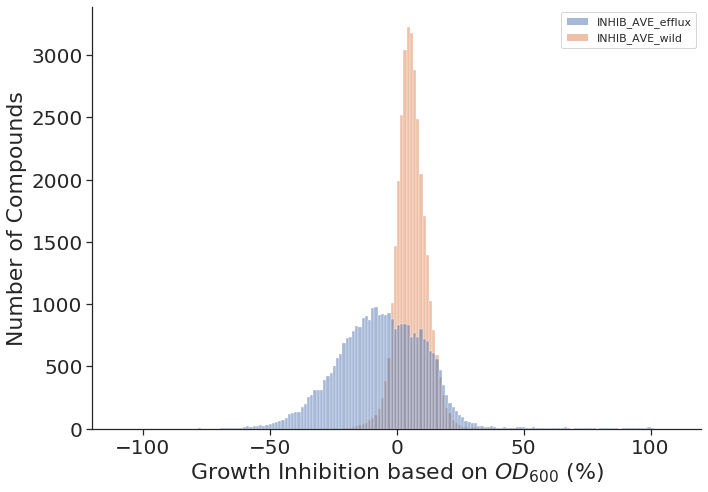

In [10]:
# e_coli_wild_efflux[['INHIB_AVE_wild', 'INHIB_AVE_efflux']].plot.hist(bins=200, alpha=0.5, figsize=[10,7])


sns.set(rc={"figure.figsize":(10, 7)})

sns.set_style("ticks")

sns.histplot(p_aer_wild_efflux[['INHIB_AVE_efflux', 'INHIB_AVE_wild']], alpha=0.5, bins=150)
sns.despine()

# plt.legend(labels = ['Wild Type', '$\Delta TolC$'],  fontsize=22)

plt.xlim([-120, 120])

plt.xlabel('Growth Inhibition based on $OD_{600}$ (%)', fontsize=22);

plt.ylabel('Number of Compounds',  fontsize=22);

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)


plt.tight_layout()
# plt.savefig('figures/hist_wild_tolc.png', dpi=600)


In [12]:
p_aer_wild_efflux.INHIB_AVE_efflux.mean(), p_aer_wild_efflux.INHIB_AVE_wild.mean()

(-5.905504754260311, 5.936266207705605)

In [13]:
stats.ttest_rel(p_aer_wild_efflux['INHIB_AVE_wild'], p_aer_wild_efflux['INHIB_AVE_efflux'])

Ttest_relResult(statistic=111.60513191316628, pvalue=0.0)

In [14]:
# z-score:
p_aer_wild_efflux['wild_stds'] = stats.zscore(p_aer_wild_efflux.INHIB_AVE_wild)
p_aer_wild_efflux['tolc_stds'] = stats.zscore(p_aer_wild_efflux.INHIB_AVE_efflux)

In [19]:
threshold = 3

def label_it(row):
    if row['wild_stds'] >=threshold:
        return 'active'
    if row['wild_stds'] <threshold:
        return 'inactive'
    
p_aer_wild_efflux['wild_class'] = p_aer_wild_efflux.apply(label_it, axis=1)

In [20]:
def label_it(row):
    if row['tolc_stds'] >=threshold:
        return 'active'
    if row['tolc_stds'] <threshold:
        return 'inactive'
    
    
p_aer_wild_efflux['tolc_class'] = p_aer_wild_efflux.apply(label_it, axis=1)

In [21]:
def label_substrate(row):
    if row['tolc_class'] == 'active' and row['wild_class'] == 'inactive':
        return 'Efflux Substrate'
    if row['tolc_class'] == 'active' and row['wild_class'] == 'active':
        return 'Efflux Evader'
    if row['tolc_class'] == 'inactive' and row['wild_class'] == 'inactive':
        return 'Inactive'
    if row['tolc_class'] == 'inactive' and row['wild_class'] == 'active':
        return 'WT-only Active'
    
p_aer_wild_efflux['Class'] = p_aer_wild_efflux.apply(label_substrate, axis=1)

In [22]:
p_aer_wild_efflux.Class.value_counts()

Inactive            32074
Efflux Substrate      176
WT-only Active         99
Efflux Evader          43
Name: Class, dtype: int64

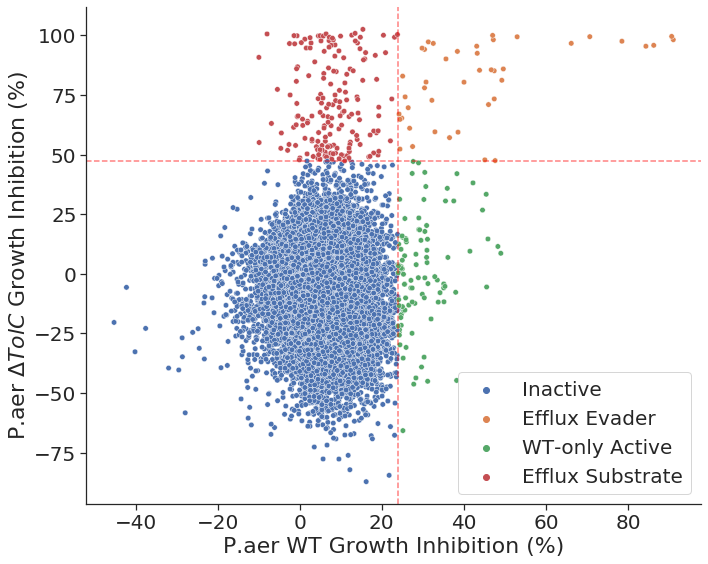

In [30]:
sns.set(rc={"figure.figsize":(10, 8)})
sns.set_style("ticks")

sns.scatterplot(data = p_aer_wild_efflux, x='INHIB_AVE_wild', y='INHIB_AVE_efflux', hue='Class', s=30)

sns.despine()

plt.legend(fontsize=20)

# plt.xlim([-120, 120])

plt.xlabel('P.aer WT Growth Inhibition (%)', fontsize=22);

plt.ylabel('P.aer $\Delta TolC$ Growth Inhibition (%)',  fontsize=22);

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.axvline(x=p_aer_wild_efflux[p_aer_wild_efflux['wild_stds']>=3].sort_values(by='wild_stds').INHIB_AVE_wild.iloc[0],  color='red', linestyle='--', alpha=0.5)
plt.axhline(y=p_aer_wild_efflux[p_aer_wild_efflux['tolc_stds']>=3].sort_values(by='tolc_stds').INHIB_AVE_efflux.iloc[0],  color='red', linestyle='--', alpha=0.5)

plt.tight_layout()

# plt.savefig('figures/wild_tolc_class_scatter.png', dpi=600)

In [27]:
p_aer_wild_efflux[p_aer_wild_efflux['wild_stds']>=4].sort_values(by='wild_stds').INHIB_AVE_wild.iloc[0]

30.25

In [28]:
p_aer_wild_efflux[p_aer_wild_efflux['tolc_stds']>=4].sort_values(by='tolc_stds').INHIB_AVE_efflux.iloc[0]

65.33